# GitHub Actions Information Needs taxonomy

## I. Dataset preparation

### 1. Data Filtering

There are three subsets of data. They correspond to filter by title, body, and tags. 
1. posts_by_title: Posts containing "Github Actions" or its variants in the question title (github actions, github-action, Github actions, Github-actions, Github Actions, Github-Actions).
2. posts_by_body: Posts containing "Github Actions" or its variants in the question body.
3. posts_by_tags: Posts tagged with any of of github actions tag list ('github-actions', 'building-github-actions', 'github-actions-self-hosted-runners', 'github-actions-runners', 'github-actions-services', 'github-actions-artifacts', 'github-actions-reusable-workflows', 'github-actions-workflows', 'github-actions-marketplace')

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Posts filtered by three filters: Title, Body, and tags.
posts_by_title = pd.read_json('data/posts_by_title.json')
posts_by_body = pd.read_json('data/posts_by_body.json')
posts_by_tags = pd.read_json('data/posts_by_tags.json')
posts_by_title.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)
posts_by_body.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)
posts_by_tags.rename(columns={"CONCAT('https://stackoverflow.com/q/', p.Id)": 'link'}, inplace=True)

In [5]:
posts_by_body = posts_by_body[posts_by_body['post_type_id']==1] # Keeping only post bodies that correspond to question bodies, removing answers bodies.
posts_by_tags.describe()

id  post_type_id  accepted_answer_id  parent_id        score  \
count  9.873000e+03        9873.0        3.670000e+03        0.0  9873.000000   
mean   7.126080e+07           1.0        7.022708e+07        NaN     2.747392   
std    5.184317e+06           0.0        5.424942e+06        NaN    11.666862   
min    5.417676e+07           1.0        5.417763e+07        NaN    -6.000000   
25%    6.796411e+07           1.0        6.622763e+07        NaN     0.000000   
50%    7.263306e+07           1.0        7.129186e+07        NaN     1.000000   
75%    7.562319e+07           1.0        7.493441e+07        NaN     2.000000   
max    7.759369e+07           1.0        7.758567e+07        NaN   348.000000   

          view_count  owner_user_id  last_editor_user_id  answer_count  \
count    9873.000000   9.801000e+03         4.271000e+03   9873.000000   
mean     2217.544718   8.707827e+06         6.605726e+06      0.981363   
std      8988.151347   6.554179e+06         6.039375e+06      1.119418   
min         5.000000   9.100000e+01        -1.000000e+00      0.000000   
25%       136.000000   2.628868e+06         1.623876e+06      0.000000   
50%       459.000000   7.764329e+06         4.290962e+06      1.000000   
75%      1385.000000   1.383621e+07         1.023495e+07      1.000000   
max    321529.000000   2.302257e+07         2.296569e+07     35.000000   

       comment_count  
count    9873.000000  
mean        1.657753  
std         2.394376  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         2.000000  
max        26.000000

In [6]:
# Number of different datasets
print("Number of posts filtered by title:", len(posts_by_title))
print("Number of posts filtered by body:", len(posts_by_body))
print("Number of posts filtered by tags :", len(posts_by_tags))
df_union = pd.concat([posts_by_tags, posts_by_title, posts_by_body]).drop_duplicates().reset_index(drop=True)
print("Number of posts of the union:", len(df_union))
df_merged_1 = pd.merge(posts_by_tags, posts_by_title, how='inner')
df_intersection = pd.merge(df_merged_1, posts_by_body, how='inner')
print("Number of posts of the intersection:", len(df_intersection))

Number of posts filtered by title: 4538
Number of posts filtered by body: 6297
Number of posts filtered by tags : 9873
Number of posts of the union: 11323
Number of posts of the intersection: 2903


In [7]:
# Number of questions tagged with the primary tag 'github-actions'
df_intersection['tags'].str.contains('<github-actions>').value_counts()

tags
True     2894
False       9
Name: count, dtype: int64

### 2. Sampling

- We have decided to use df_intersection because we consider that we are ensuring that the topic is for sure related to GitHub Actions because it is tagged and mentioned in the title and the body question. 

- We decided to select a random sample.

- 340 posts or more are needed to have a confidence level of 95% that the real value is within ±5%.

In [32]:
# Creating the random sample. We are accepting the first 340 posts that we consider are related to the topic.
sample_size = 400
seed = 0
df_sample = df_intersection.sample(n=sample_size, random_state=seed)
print("Sample length: ", df_sample.shape[0])
df_sample.head();

Sample length:  400


### 3. Manual examination

- Two authors examinated the posts manually in order the removing posts that were not GA related or links that did not work. Finally, 340 posts were accepted.

In [33]:
# Creating the files that will be examinated by two evaluators
df_sample[['id', 'link']].assign(evaluator1=np.nan).to_excel('data/sample_eval1.xlsx')
df_sample[['id', 'link']].assign(evaluator2=np.nan).to_excel('data/sample_eval2.xlsx')

In [34]:
# Posts that are accepted by both evaluators were accepted.
sample_reviewed=pd.read_excel('data/sample_eval1_reviewed.xlsx')
sample_reviewed['evaluator2']=pd.read_excel('data/sample_eval2_reviewed.xlsx')['evaluator2']
sample_accepted=sample_reviewed[(sample_reviewed['evaluator1']==1)&(sample_reviewed['evaluator2']==1)].head(340)
sample_accepted = pd.merge(df_intersection, sample_accepted[['id']], on='id', how='inner')
sample_accepted.to_excel('data/sample_accepted.xlsx')
sample_accepted.head(3);

### 4. Coding in sentences

Body text was parsed from html to plain text. Removing code, blocks, or links. Usually images are also links. After that, text was divided in sentences.

In [35]:
from bs4 import BeautifulSoup
import re

def html_to_sentences_df(html_content):
    """
    Parses the provided HTML content, replaces specific tags with placeholders, adjusts paragraph endings, and splits the content into sentences. 
    Returns a pandas DataFrame with each sentence in a separate row.
    
    Parameters:
    - html_content: String containing HTML content.
    
    Returns:
    - DataFrame with each sentence as a separate row.
    """
    
    # Parse the HTML
    soup = BeautifulSoup(html_content, 'html.parser')

    # Replace code blocks, blockquotes, and links with placeholders
    for code in soup.find_all('code'):
        code.replace_with("-CODE-")
    for blockquote in soup.find_all('blockquote'):
        blockquote.replace_with("-BLOCK-")
    for a in soup.find_all('a'):
        a.replace_with("-LINK-")

    # Extract text and replace newline entities
    text = soup.get_text()
    text = text.replace('&#xA;', '\n').strip()

    # Pre-process text to handle ':\\n-CODE-' pattern
    text = re.sub(r':\s*\n-CODE-', ': -CODE-', text)
    text = re.sub(r':\s*\n-BLOCK-', ': -BLOCK-', text)
    text = re.sub(r':\s*\n-LINK-', ': -LINK-', text)
    
    # Adjust paragraph endings where necessary
    pattern = r'(?<![\.\!\?\s])\s*\n'
    text = re.sub(pattern, '.\n', text)

    # Replace ':.' with ':'
    text = text.replace(':.', ':')

    # Split text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text.replace('\n', ' '))

    # Create DataFrame
    df = pd.DataFrame(sentences, columns=['sentence'])
    
    return df

In [36]:
def process_df(sample_df):
    # Initialize an empty DataFrame to hold all sentences
    all_sentences_df = pd.DataFrame()

    # Iterate over each row in the DataFrame
    for index, row in sample_df.iterrows():

        # Process the title and body, assuming they are HTML content
        title_sentences_df = html_to_sentences_df(row['post_title'])
        body_sentences_df = html_to_sentences_df(row['post_body'])

        # Add a column with the index/id of the post
        title_sentences_df['id'] = index
        body_sentences_df['id'] = index

        # Add a column with the index/id of the post
        title_sentences_df['post_id'] = row['id']
        body_sentences_df['post_id'] = row['id']

        # Add a column to indicate the source of the sentences
        title_sentences_df['source'] = 'title'
        body_sentences_df['source'] = 'body'
        
        # Combine title and body sentences
        combined_sentences_df = pd.concat([title_sentences_df, body_sentences_df], ignore_index=True)
        
        # Add the combined sentences to the overall DataFrame
        all_sentences_df = pd.concat([all_sentences_df, combined_sentences_df], ignore_index=True)

        all_sentences_df = all_sentences_df[['id', 'post_id', 'source', 'sentence']]

    return all_sentences_df

all_sentences_df = process_df(sample_accepted) # this df contains all the sentences from the sample of 340 posts.

C:\Users\shern\AppData\Local\Temp\ipykernel_42560\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_42560\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_42560\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, 'html.parser')
C:\Users\shern\AppData\Local\Temp\ipykernel_42560\190409919.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open thi

----------------------------------------------------------------

## II. Manual classification

### 1. Pre-classification

We create a pre-categorization using a small sample of 50 posts. 13 categories were established. Afterwards, we classfified the rest of them redefining these categories.

In [37]:
# Creating files for the evaluators

categories = [1, 4, 5, 7, 2, 9, 13, 11, 14, 20, 22, 19, 23]
# Add each new column filled with zeros to the DataFrame
for column in categories:
    all_sentences_df[column] = 0

all_sentences_df.to_excel('data/sentences_eval1.xlsx')
all_sentences_df.to_excel('data/sentences_eval2.xlsx')

In [38]:
classified_sentences_eval1 = pd.read_excel('data/sentences_eval1_reviewed.xlsx')
classified_sentences_eval2 = pd.read_excel('data/sentences_eval2_reviewed.xlsx')

In [39]:
# Kappa-Cohen scores of the evaluators classifications 

import pandas as pd
from sklearn.metrics import cohen_kappa_score

kappa = pd.DataFrame()
for category in classified_sentences_eval1.columns.drop(['Unnamed: 0', 'id', 'post_id', 'source', 'sentence']):
    kappa[category] = [cohen_kappa_score(classified_sentences_eval1[category], classified_sentences_eval2[category])]

kappa

1         4         5         7    2         9         13        11  \
0  0.562396  0.340006  0.326081  0.214155  0.0  0.487878 -0.000294  0.189686   

    14        20       22   19   23  
0  0.0  0.451206  0.36159  0.0  0.0

In [40]:
#sample_json = sample_accepted.to_json(orient='records', lines=False, indent=4)
#print(sample_json)

### 2. Information Needs and Relevant Information taxonomy

After performing manually the taxonomy, we identified 8 Information Needs (DN), and 24 Relevant Information (RI) groups. 
The 8 DN are: Error Handling (EH), Incompatibility (IN), Insufficient Implementation (II), Migration (MI), Functionality Implementation (FI), Orientation (OR), Alternative Solution (AS), and GHA Learning (LE).

In [41]:
DN_list = ['EH', 'IN', 'II', 'MI', 'FI', 'OR', 'AS', 'LE']
sentences_classified = pd.read_excel("data/sentences_taxonomy.xlsx", sheet_name=DN_list)
sample_sentences = pd.DataFrame()
for k in sentences_classified.keys():
    sentences_classified[k].drop_duplicates(inplace=True)
    sample_sentences = pd.concat([sample_sentences, sentences_classified[k]], ignore_index=True)
sample_sentences = pd.concat([sample_sentences, pd.get_dummies(sample_sentences['RI_id'], dtype=int)], axis=1)

In [42]:
sample_sentences.sort_values(by=['sentence_id'], inplace=True)
sample_sentences.drop(['RI_id'], axis=1, inplace=True)

In [43]:
# List of Relevant Information id's
RI_list = sample_sentences.columns[5:]

In [44]:
# Merging duplicated sentences with different RI categories.
agg_dict = dict()
agg_dict['id'] = 'first'
agg_dict['post_id'] = 'first'
agg_dict['source'] = 'first'
agg_dict['sentence'] = 'first'
agg_dict.update({col: 'sum' for col in RI_list})
sample_sentences = sample_sentences.groupby('sentence_id').agg(agg_dict).reset_index()
sample_sentences;

There are 1000 sentences that contain one or more types of Relevant Information.

In [45]:
# Creating a DF with all the sentences of the sample and their categorization

all_sentences_df = all_sentences_df.drop(columns=categories, axis=1)

# Add each new column filled with zeros to the DataFrame
for column in RI_list:
    all_sentences_df[column] = 0
all_sentences_df.index.name = 'sentence_id'

for i in range(len(all_sentences_df)):
    for j in range(len(sample_sentences)):
        if i == sample_sentences.loc[j, 'sentence_id']:
            all_sentences_df.loc[i, RI_list] = sample_sentences.loc[j, RI_list]
all_sentences_df

id   post_id source  \
sentence_id                         
0              0  57503578  title   
1              0  57503578   body   
2              0  57503578   body   
3              0  57503578   body   
4              0  57503578   body   
...          ...       ...    ...   
3171         339  77519735   body   
3172         339  77519735   body   
3173         339  77519735   body   
3174         339  77519735   body   
3175         339  77519735   body   

                                                      sentence  AS1  EH1  EH2  \
sentence_id                                                                     
0            Making pull requests to a GitHub repository au...    0    0    0   
1            I have a file in a GitHub repository that need...    0    0    0   
2            As part of a -LINK-, I want to have a bot runn...    0    0    0   
3            I have a suspicion that the -LINK- can help me...    0    0    0   
4            I see some official automation workflows that ...    0    0    0   
...                                                        ...  ...  ...  ...   
3171                                                   -CODE-.    0    0    0   
3172                                Below is an error message.    0    0    0   
3173                                                   -CODE-.    0    0    0   
3174         I searched for an error message, but I couldn'...    0    0    0   
3175             How do I make modifications to work normally?    0    0    0   

             EH3  EH4  EH5  ...  LE2  LE3  MI1  OR1  OR2  OR3  OR4  OR5  OR6  \
sentence_id                 ...                                                
0              0    0    0  ...    0    0    0    0    0    0    0    0    0   
1              0    0    0  ...    0    0    0    0    0    0    0    0    0   
2              0    0    0  ...    0    0    0    0    0    0    0    0    0   
3              0    0    0  ...    0    0    0    0    0    0    0    0    0   
4              0    0    0  ...    0    0    0    0    0    0    0    0    0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3171           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3172           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3173           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3174           0    0    0  ...    0    0    0    0    0    0    0    0    0   
3175           0    0    0  ...    0    0    0    0    0    0    0    0    0   

             OR7  
sentence_id       
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
3171           0  
3172           0  
3173           0  
3174           0  
3175           0  

[3176 rows x 28 columns]

In [48]:
# Saving results as a json 

grouped = {} #

for index, row in all_sentences_df.iterrows():
    post_id = row['post_id']
    # Structure for each sentence
    sentence_data = {
        'post_id': post_id,
        'source': row['source'],
        'sentence': row['sentence'],
        'DN': {
            'AS': {'AS1': row['AS1']},
            'EH': {'EH1': row['EH1'], 'EH2': row['EH2'], 'EH3': row['EH3'], 'EH4': row['EH4'], 'EH5': row['EH5'], 'EH6': row['EH6'], 'EH7': row['EH7'], 'EH8': row['EH8'], 'EH9': row['EH9']},
            'FI': {'FI1': row['FI1']},
            'II': {'II1': row['II1']},
            'IN': {'IN1': row['IN1']},
            'LE': {'LE1': row['LE1'], 'LE2': row['LE2'], 'LE3': row['LE3']},
            'MI': {'MI1': row['MI1']},
            'OR': {'OR1': row['OR1'], 'OR2': row['OR2'], 'OR3': row['OR3'], 'OR4': row['OR4'], 'OR5': row['OR5'], 'OR6': row['OR6'], 'OR7': row['OR7']}
        }
    }
    # Append to the list for the corresponding post_id in the result dictionary
    if post_id in grouped:
        grouped[post_id].append(sentence_data)
    else:
        grouped[post_id] = [sentence_data]

sample_df = sample_accepted.copy()
sample_df['sentences'] = sample_df['id'].map(grouped)
sample_df

sample_json = sample_df.to_json(orient='records', indent=4)
with open('data/sample_classified.json', 'w') as f:
    f.write(sample_json)
    
print(sample_json)

[
    {
        "id":57503578,
        "post_type_id":1,
        "accepted_answer_id":null,
        "parent_id":null,
        "creation_date":"2019-08-15 00:30:14",
        "score":13,
        "view_count":7788,
        "post_body":"<p>I have a file in a GitHub repository that needs updating occasionally by running a command.<\/p>&#xA;&#xA;<p>As part of a <a href=\"https:\/\/help.github.com\/en\/articles\/configuring-a-workflow\" rel=\"noreferrer\">GitHub Workflows<\/a>, I want to have a bot running a command, and seeing if it creates  a diff on the repo, and if so, make a pull request to the repository automatically. <\/p>&#xA;&#xA;<p>I have a suspicion that the <a href=\"https:\/\/help.github.com\/en\/articles\/configuring-a-workflow\" rel=\"noreferrer\">GitHub Workflows<\/a> can help me do that as GitHub now lets people run arbitrary containers (\"Actions\") that do stuff like builds in a repository. I see some official automation workflows that let you \"label\" and \"comment\" iss

----------------------------------------------------------------

## III. Taxonomy Evaluation

### Orthogonality

According to the references paper: https://dl.acm.org/doi/abs/10.1145/3530019.3535305
They propose a 3-Step Evaluation: Suitable structure, Applicability, and Purpose.
Step 1 evaluates 5 criterias: Laconicity, Ludicity, Completeness, Soundness, and Orthogonality Matrix.

In [49]:
# Calculates the orthogonality matrix

def calculate_orthogonality_matrix(df, class_columns):
    R = df[class_columns].values
    num_classes = R.shape[1]
    orthogonality_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                # Check if there is any overlap between classes i and j
                #if np.any(R[:, i] & R[:, j]):
                #    orthogonality_matrix[i, j] = 1.0
                # orthogonality_matrix[i, j] = np.sum(R[:, i] & R[:, j])

                # Calculate the percentage with respect to the number of elements in class i
                overlap_count = np.sum(R[:, i] & R[:, j])
                total_elements_class_i = np.sum(R[:, i])
                if total_elements_class_i > 0:
                    orthogonality_matrix[i, j] = (overlap_count / total_elements_class_i) * 100
                else:
                    orthogonality_matrix[i, j] = 0.0

    return orthogonality_matrix

orthogonality_matrix = calculate_orthogonality_matrix(sample_sentences, RI_list)
print(f'Relevant Information:\n{RI_list[:]}')
print(f'Orthogonality Matrix:\n{orthogonality_matrix}')

Relevant Information:
Index(['AS1', 'EH1', 'EH2', 'EH3', 'EH4', 'EH5', 'EH6', 'EH7', 'EH8', 'EH9',
       'FI1', 'II1', 'IN1', 'LE1', 'LE2', 'LE3', 'MI1', 'OR1', 'OR2', 'OR3',
       'OR4', 'OR5', 'OR6', 'OR7'],
      dtype='object')
Orthogonality Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  1  0  5  4  5 20 12  7  3  2  4  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0 62  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0 25  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0 35  0  7  0  0  7  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  6  1  6  0  0  1  8  2  5  5  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 45  0  0  0  0  0  9  0  9  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  1  1  1  1  0  1  4  4  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0 11  0  1  0  1  0  1  4  3  0  0  0  0  1  0  0  0  0  0]
 [ 0 11  0  1  0  3  1  4  1  0  1  0  1  0  0  0  0  0  1  0  0  0  

### Scenario 1 and 2: using all the sentences and only relevant sentences 

In [52]:
# Calculate Laconicity, Completeness, Lucidity, and Soundness

def calculate_evaluation_structure(df_sentences):
    sum_RIs = np.sum(df_sentences[RI_list].values, axis=0)
    sum_sentences = np.sum(df_sentences[RI_list].values, axis=1)
    laconicity = np.mean(sum_sentences <=1)
    completeness = np.mean(sum_sentences >= 1)
    lucidity = np.mean(sum_RIs <= 1)
    soundness = np.mean(sum_RIs >= 1)
    dict = {'Laconicity': laconicity, 'Completeness': completeness, 'Lucidity': lucidity, 'Soundness': soundness}
    return dict

In [51]:
print("Using only relevant sentences: ", calculate_evaluation_structure(sample_sentences))
print("Using all the sentences: ", calculate_evaluation_structure(all_sentences_df))

Using only relevant sentences:  {'Laconicity': 0.882, 'Completeness': 1.0, 'Lucidity': 0.0, 'Soundness': 1.0}
Using all the sentences:  {'Laconicity': 0.9628463476070529, 'Completeness': 0.3148614609571788, 'Lucidity': 0.0, 'Soundness': 1.0}


### Scenario 3 and 4: By Post with and without irrelevant sentences

In [62]:
# Create metric plots

import matplotlib.pyplot as plt

def plot_metrics(df):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot Laconicity vs post_id
    axs[0, 0].plot(df['post_id'], df['Laconicity'], marker='o', linestyle='None')
    axs[0, 0].set_xlabel('Post ID')
    axs[0, 0].set_ylabel('Laconicity')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].set_title('Laconicity vs Post ID')
    axs[0, 0].grid(True)

    # Plot Completeness vs post_id
    axs[0, 1].plot(df['post_id'], df['Completeness'], marker='o', linestyle='None')
    axs[0, 1].set_xlabel('Post ID')
    axs[0, 1].set_ylabel('Completeness')
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].set_title('Completeness vs Post ID')
    axs[0, 1].grid(True)

    # Plot Lucidity vs post_id
    axs[1, 0].plot(df['post_id'], df['Lucidity'], marker='o', linestyle='None')
    axs[1, 0].set_xlabel('Post ID')
    axs[1, 0].set_ylabel('Lucidity')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].set_title('Lucidity vs Post ID')
    axs[1, 0].grid(True)

    # Plot Soundness vs post_id
    axs[1, 1].plot(df['post_id'], df['Soundness'], marker='o', linestyle='None')
    axs[1, 1].set_xlabel('Post ID')
    axs[1, 1].set_ylabel('Soundness')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].set_title('Soundness vs Post ID')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

Considering only relevant sentences:

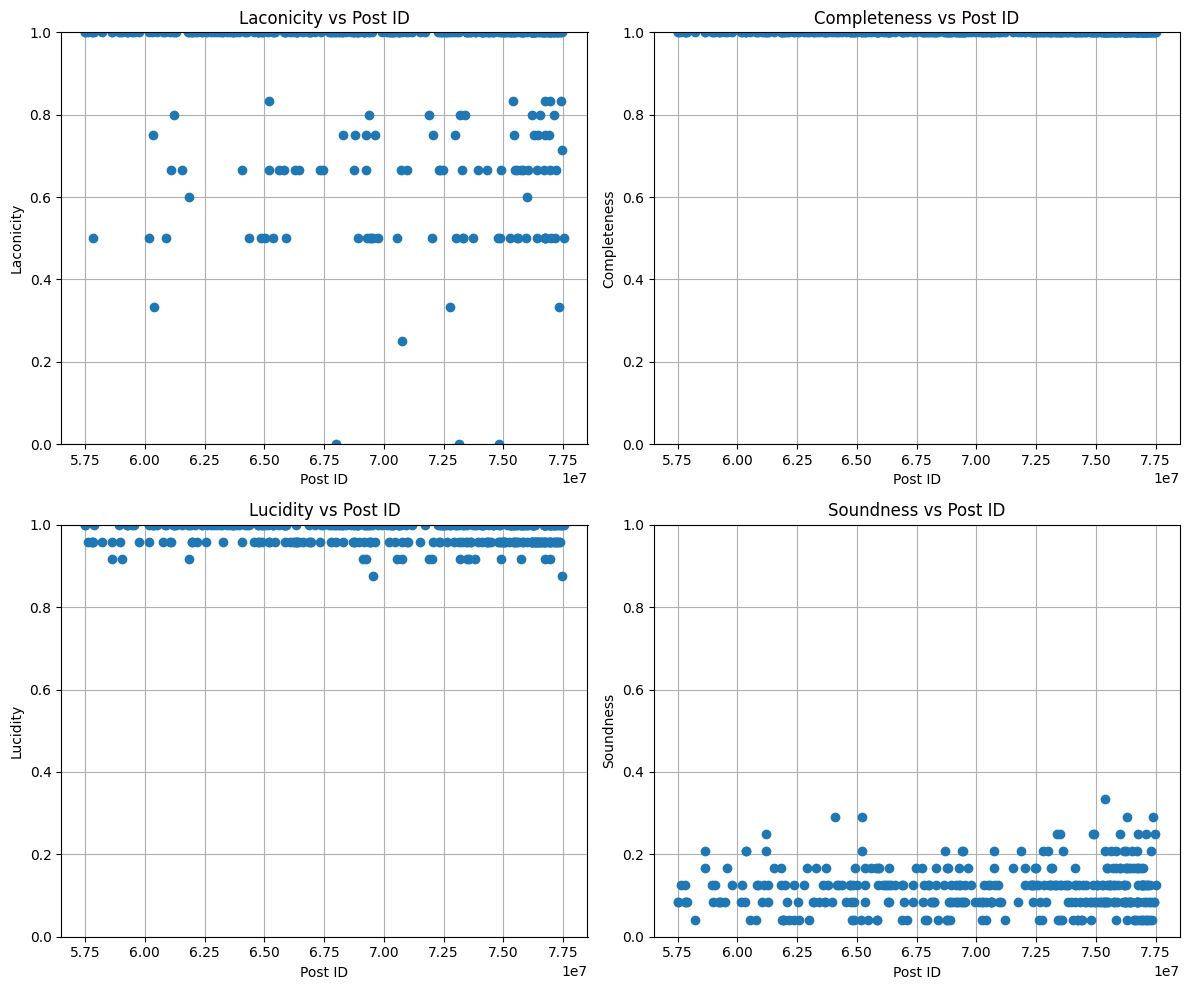

Mean values for the structure parameters:
 post_id         7.029749e+07
Laconicity      8.824280e-01
Completeness    1.000000e+00
Lucidity        9.794162e-01
Soundness       1.163922e-01
dtype: float64


In [68]:
metrics = sample_sentences.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

Considering all the sentences:

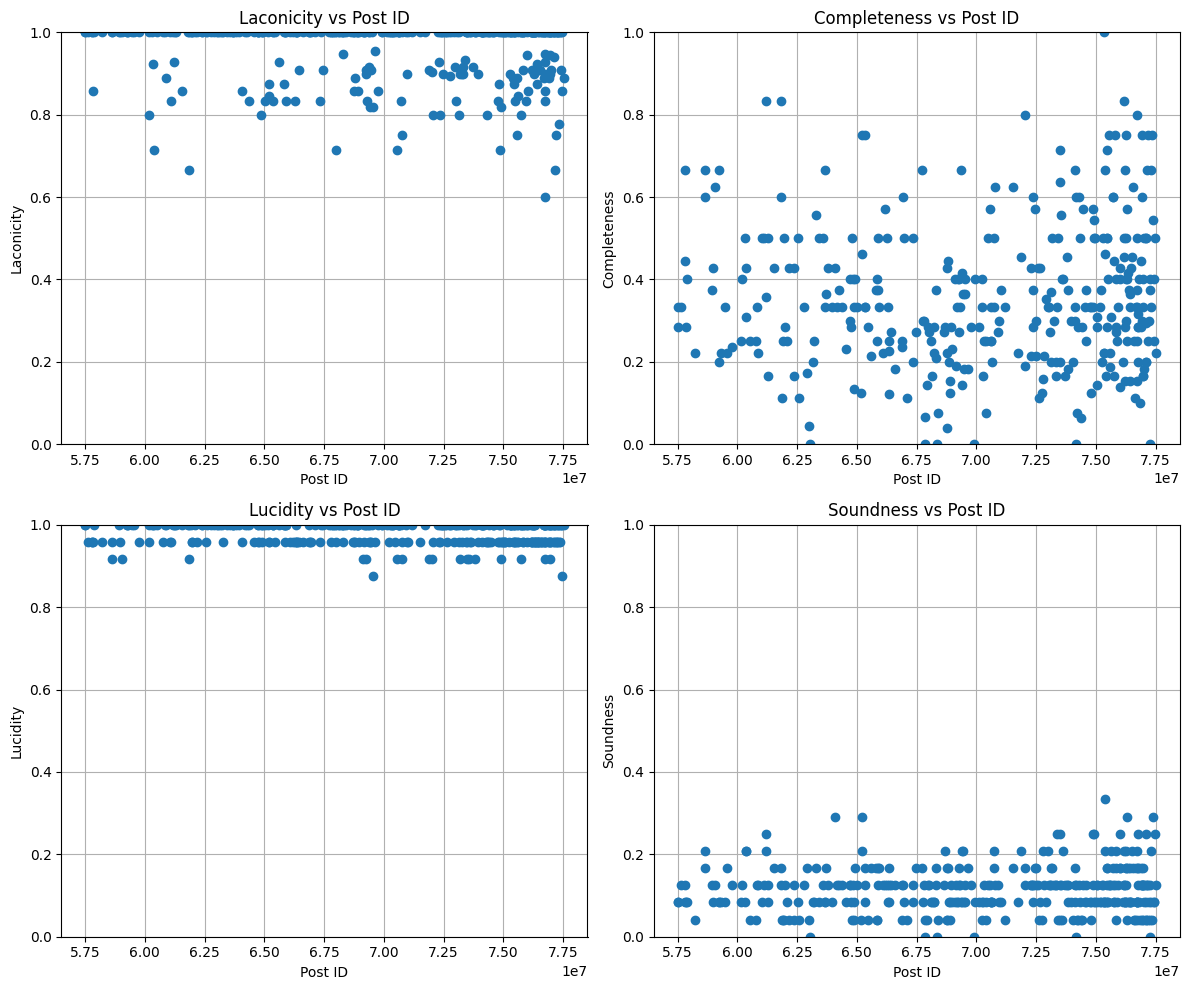

Mean values for the structure parameters:
 post_id         7.029407e+07
Laconicity      9.590664e-01
Completeness    3.559708e-01
Lucidity        9.797794e-01
Soundness       1.143382e-01
dtype: float64


In [69]:
metrics = all_sentences_df.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

### Scenario 5: Adding a new category for Non-Relevant 'NR' sentences

{'Laconicity': 0.9628463476070529, 'Completeness': 1.0, 'Lucidity': 0.0, 'Soundness': 1.0}


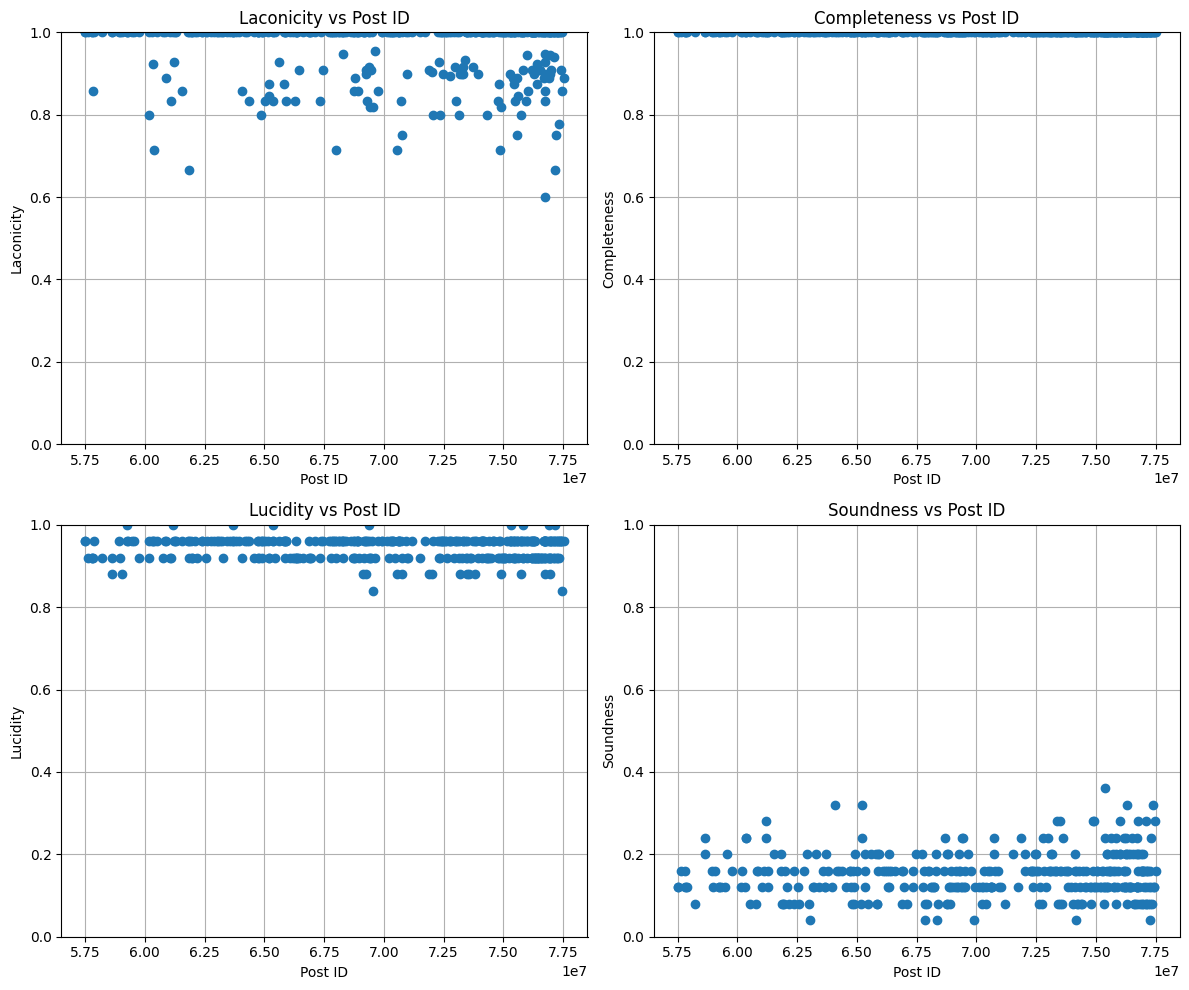

Mean values for the structure parameters:
 post_id         7.029407e+07
Laconicity      9.590664e-01
Completeness    1.000000e+00
Lucidity        9.424706e-01
Soundness       1.496471e-01
dtype: float64


In [70]:
all_sentences_plus_NR = all_sentences_df.copy()
all_sentences_plus_NR['NR'] = all_sentences_plus_NR[RI_list].sum(axis=1)+1
all_sentences_plus_NR.loc[all_sentences_plus_NR['NR'] > 1, 'NR'] = 0

sample_sentences_plus_NR = sample_sentences.copy()
sample_sentences_plus_NR['NR'] = sample_sentences_plus_NR[RI_list].sum(axis=1)+1
sample_sentences_plus_NR.loc[sample_sentences_plus_NR['NR'] > 1, 'NR'] = 0


def calculate_evaluation_structure(df_sentences):
    RI_list_NR = RI_list.append(pd.Index(['NR']))
    sum_RIs = np.sum(df_sentences[RI_list_NR].values, axis=0)
    sum_sentences = np.sum(df_sentences[RI_list_NR].values, axis=1)
    laconicity = np.mean(sum_sentences <=1)
    completeness = np.mean(sum_sentences >= 1)
    lucidity = np.mean(sum_RIs <= 1)
    soundness = np.mean(sum_RIs >= 1)
    dict = {'Laconicity': laconicity, 'Completeness': completeness, 'Lucidity': lucidity, 'Soundness': soundness}
    return dict


print(calculate_evaluation_structure(all_sentences_plus_NR))

metrics = all_sentences_plus_NR.groupby('post_id').apply(calculate_evaluation_structure)
df_to_plot = pd.DataFrame({
    'post_id': metrics.index,
    'Laconicity': metrics.apply(lambda x: x['Laconicity']),
    'Completeness': metrics.apply(lambda x: x['Completeness']),
    'Lucidity': metrics.apply(lambda x: x['Lucidity']),
    'Soundness': metrics.apply(lambda x: x['Soundness'])
})
plot_metrics(df_to_plot)
print("Mean values for the structure parameters:\n", df_to_plot.mean())

----------------------------------------------------------------

# IV. Results and Analysis

----------------------------------------------------------------

## Appendice

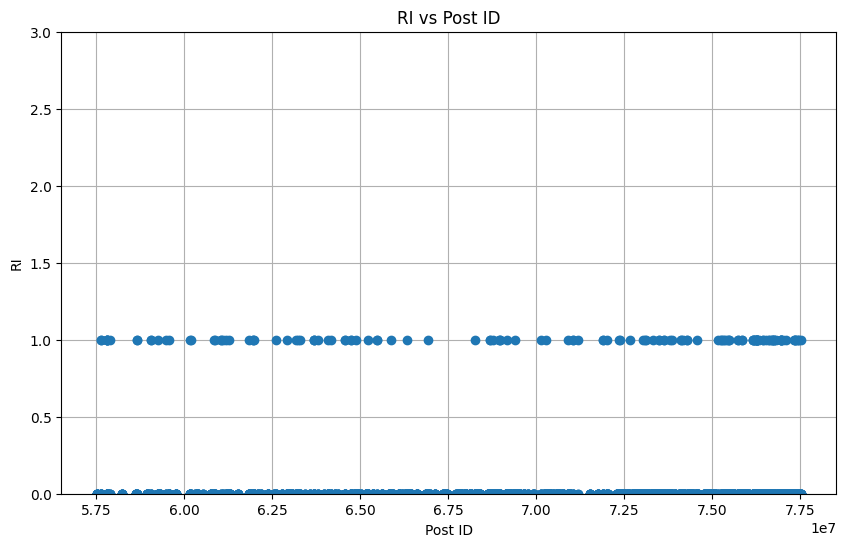

In [44]:
import matplotlib.pyplot as plt

# Plot Completeness vs post_id
plt.figure(figsize=(10, 6))
plt.plot(all_sentences_df['post_id'], all_sentences_df['LE1'], marker='o', linestyle='None')
plt.xlabel('Post ID')
plt.ylabel('RI')
plt.title('RI vs Post ID')
plt.ylim(0,3)
plt.grid(True)
plt.show()

In [45]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# List of sentences
sentences = [
    "Is there a way to deploy code to AWS EC2 without using Elastic Beanstalk?",
    "Is there a way to set the password so the runner stops asking me every single time?",
    "Is there an off the self way to report all Checkstyle XML warnings and errors as pull-request",
    "Maybe there is something fundamental that I don't quite get regarding port forwarding.",
    "I want to know if is there any way to generate the EJbs code without a server installation available, and if not, if is there any way to have an installation of the server available in the pipeline in order to this work (pipeline is running over ubuntu-18.04)"
]

# Function to extract POS tags from a sentence
def extract_pos_tags(sentence):
    doc = nlp(sentence.lower())
    return ' '.join([token.pos_ for token in doc])

# Extract POS tags for each sentence
pos_sentences = [extract_pos_tags(sentence) for sentence in sentences]

# Vectorize the POS tag sequences
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(pos_sentences)

# Cluster the sentences using KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

# Print the clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for idx, label in enumerate(kmeans.labels_):
        if label == i:
            print(f"  {sentences[idx]}")


C:\Users\shern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
  Is there a way to deploy code to AWS EC2 without using Elastic Beanstalk?
  Is there an off the self way to report all Checkstyle XML warnings and errors as pull-request
Cluster 1:
  I want to know if is there any way to generate the EJbs code without a server installation available, and if not, if is there any way to have an installation of the server available in the pipeline in order to this work (pipeline is running over ubuntu-18.04)
Cluster 2:
  Maybe there is something fundamental that I don't quite get regarding port forwarding.
Cluster 3:
  Is there a way to set the password so the runner stops asking me every single time?


In [47]:
all_sentences_df.head(15)

id   post_id source  \
sentence_id                        
0             0  57503578  title   
1             0  57503578   body   
2             0  57503578   body   
3             0  57503578   body   
4             0  57503578   body   
5             0  57503578   body   
6             0  57503578   body   
7             1  57509118  title   
8             1  57509118   body   
9             1  57509118   body   
10            1  57509118   body   
11            1  57509118   body   
12            1  57509118   body   
13            2  57639507  title   
14            2  57639507   body   

                                                      sentence  AS1  EH1  EH2  \
sentence_id                                                                     
0            Making pull requests to a GitHub repository au...    0    0    0   
1            I have a file in a GitHub repository that need...    0    0    0   
2            As part of a -LINK-, I want to have a bot runn...    0    0    0   
3            I have a suspicion that the -LINK- can help me...    0    0    0   
4            I see some official automation workflows that ...    0    0    0   
5            If I wanted to run an arbitrary command and ma...    0    0    0   
6                                Any pointers are appreciated.    0    0    0   
7                      New GitHub actions run in empty folders    0    0    0   
8            I am working with new GitHub actions, idea of ...    0    0    0   
9                                                      -CODE-.    0    0    0   
10           At the moment it successfully gets to a checko...    0    1    0   
11                                                    -BLOCK-.    0    0    0   
12           Judging by this checkout either failed or I am...    0    0    0   
13            How to access a service in Github Actions CI/CD?    0    0    0   
14           I'm trying to set up a CI/CD pipeline in GitHu...    0    0    0   

             EH3  EH4  EH5  ...  LE2  LE3  MI1  OR1  OR2  OR3  OR4  OR5  OR6  \
sentence_id                 ...                                                
0              0    0    0  ...    0    0    0    0    0    0    0    0    0   
1              0    0    0  ...    0    0    0    0    0    0    0    0    0   
2              0    0    0  ...    0    0    0    0    0    0    0    0    0   
3              0    0    0  ...    0    0    0    0    0    0    0    0    0   
4              0    0    0  ...    0    0    0    0    0    0    0    0    0   
5              0    0    0  ...    0    0    0    0    0    0    0    0    1   
6              0    0    0  ...    0    0    0    0    0    0    0    0    0   
7              0    0    0  ...    0    0    0    0    0    0    0    0    0   
8              0    0    0  ...    0    0    0    0    0    0    0    0    0   
9              0    0    0  ...    0    0    0    0    0    0    0    0    0   
10             0    0    0  ...    0    0    0    0    0    0    0    0    0   
11             0    0    0  ...    0    0    0    0    0    0    0    0    0   
12             0    0    0  ...    0    0    0    0    0    1    0    0    0   
13             0    0    0  ...    0    0    0    0    0    0    0    0    0   
14             0    0    0  ...    0    0    0    0    0    0    0    0    0   

             OR7  
sentence_id       
0              0  
1              0  
2              0  
3              0  
4              0  
5              0  
6              0  
7              0  
8              0  
9              0  
10             0  
11             0  
12             0  
13             0  
14             0  

[15 rows x 28 columns]